# RentHop House Listing Price Prediction

The final project for DS-GA1001 Introduction to Data Science

## Package Import

In [72]:
%matplotlib inline
# Python
from collections import defaultdict
# Data Analysis
import numpy as np # linear algebra
import scipy as sp
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
# I/O
import os
# Plot
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns

## Data Exploration and Preprocessing

Read data and look at the variables we have

In [2]:
def data_cleaning(infile):
    # Import Data
    df = pd.read_json("../data/train.json")
    print df.shape
    return df
df = data_cleaning('../data/train.json')
df.head()

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,-73.9677,1067e078446a7897d2da493d2f741316,[https://photos.renthop.com/2/6888711_6e660cee...,3275,333 East 49th Street
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,-73.9493,98e13ad4b495b9613cef886d79a6291f,[https://photos.renthop.com/2/6934781_1fa4b41a...,3350,500 West 143rd Street


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


## Split Training Set and Test Set

We are spliting the available data into training set and test set

In [4]:
def data_split(df):
    df_y = df[['price']]
    df_X = df.drop('price', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = data_split(df)
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(39481, 14) (9871, 14) (39481, 1) (9871, 1)


### --------- From now on, we only use the training set for modeling and validation ---------

## Data Explorations

### Addresses

We use displayed address and see what are the most frequently listed addresses

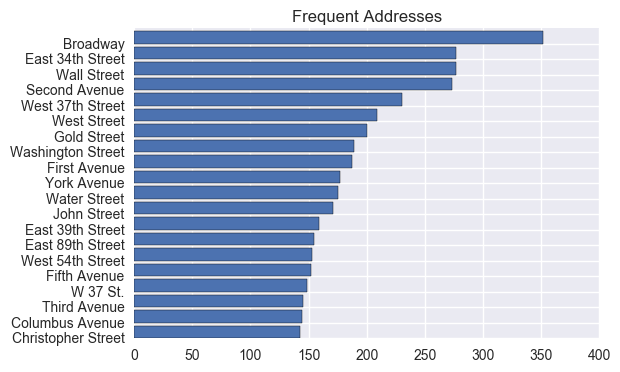

In [131]:
address_counts = X_train['display_address'].value_counts()
plt.figure()
plt.barh(range(len(address_counts))[:20],address_counts.values[:20][::-1],tick_label=address_counts.index[:20][::-1])
plt.title('Frequent Addresses')
# Most frequently used addresses
plt.show()

### Target Variable (Price)

We observe that the price is skewed to the right, so we may take log of price data before training model

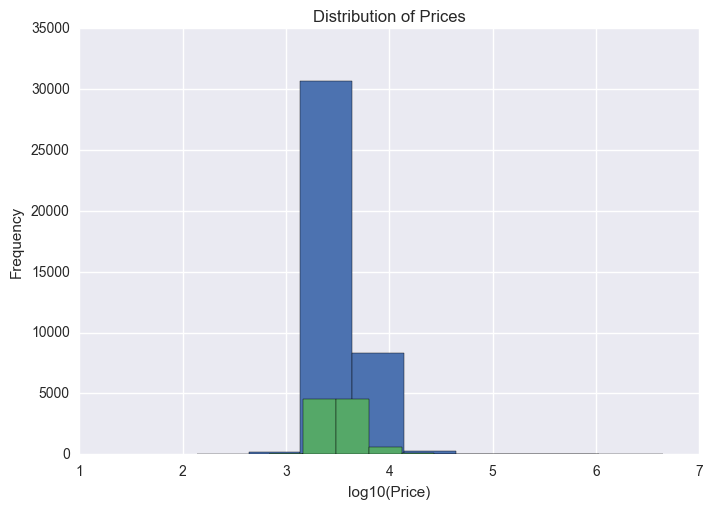

In [6]:
plt.figure()
plt.hist(np.log10(y_train.values))
plt.hist(np.log10(y_test.values))
plt.title('Distribution of Prices')
plt.xlabel('log10(Price)')
plt.ylabel('Frequency')
plt.show()

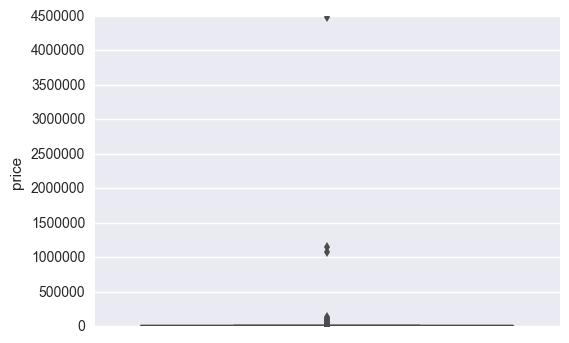

In [157]:
sns.boxplot(y_train['price'], orient='v')

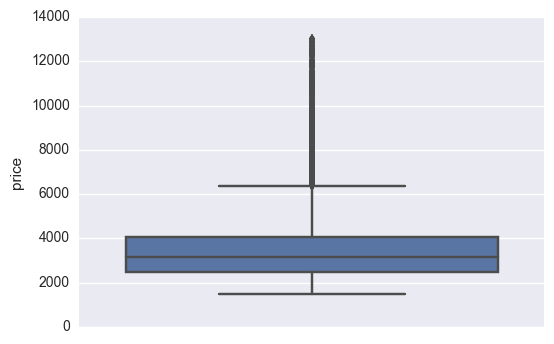

In [138]:
[low, high] = y_train['price'].quantile([0.01,0.99]).values
sns.boxplot(y_train[(y_train['price'] <= high) & (y_train['price'] >= low)]['price'], orient='v')

### Features

We filter out some features that appear multiple times (> 50) among all training samples. We make them lower cases before hand

<Container object of 82 artists>

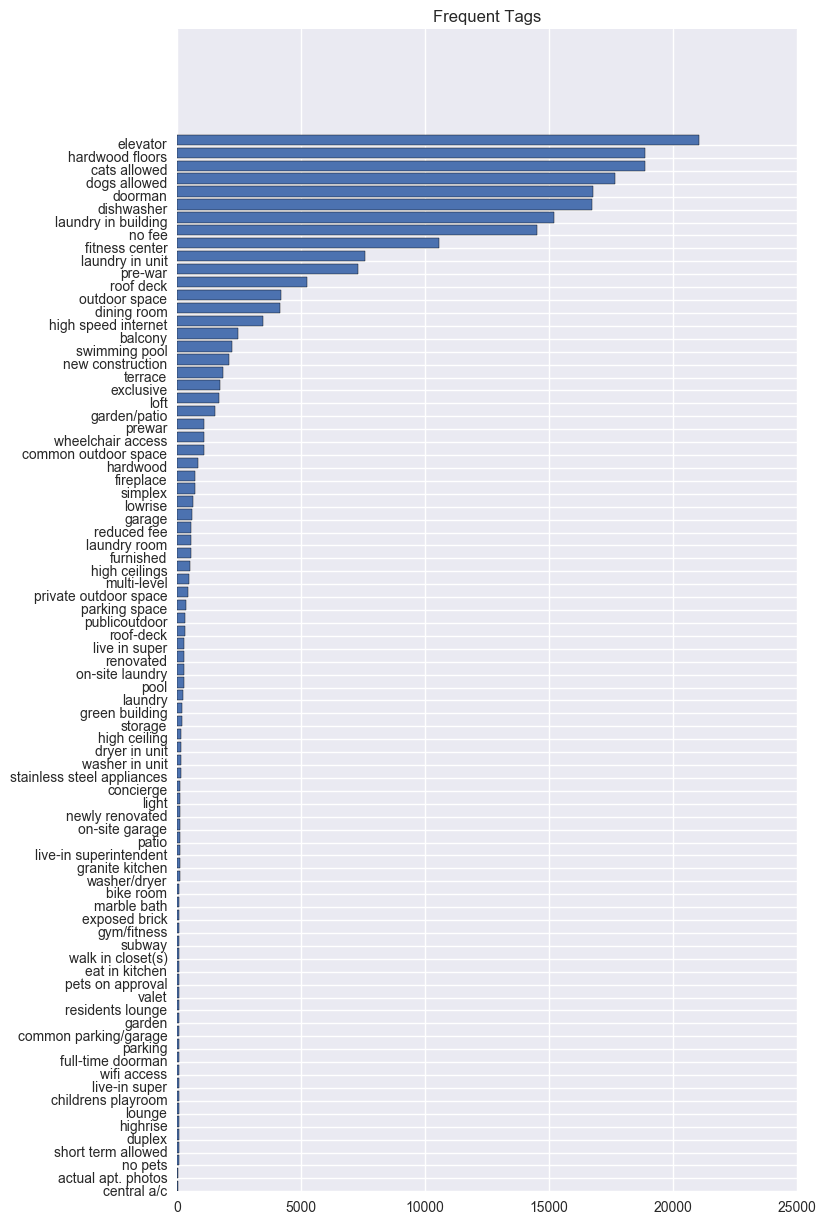

In [7]:
# Extract all features
all_features = defaultdict(int)
for f in X_train['features']:
    for i in f:
        i = i.lower() # Convert to lower cases
        all_features[i] = all_features[i] + 1
all_features_sorted = []
for kk,vv in all_features.items():
    if vv > 50: # Appear more than a certain times
        all_features_sorted.append((kk,vv))
# Take a look at the most frequently listed features
all_features_sorted = sorted(all_features_sorted, key=lambda x: x[1])
all_features_index = map(lambda x: x[0], all_features_sorted)
all_features_values = map(lambda x: x[1], all_features_sorted)
plt.figure(figsize=(8, 15))
plt.title('Frequent Tags')
plt.barh(range(len(all_features_sorted)), all_features_values,tick_label=all_features_index)

### Price wrt number of bathrooms

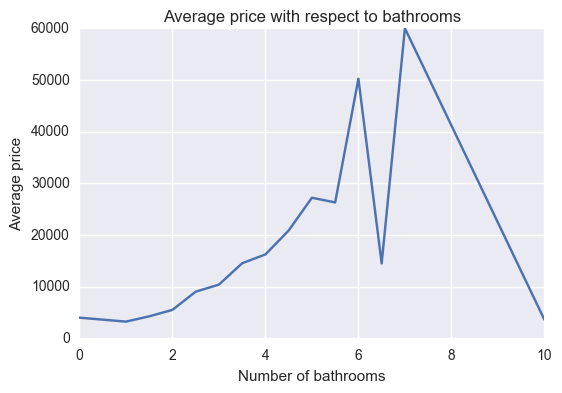

In [153]:
avg_price_bedrooms = df['price'].groupby(df['bathrooms']).mean()
plt.figure()
plt.plot(avg_price_bedrooms.index, avg_price_bedrooms.values)
plt.title('Average price with respect to bathrooms')
plt.xlabel('Number of bathrooms')
plt.ylabel('Average price')
plt.show()

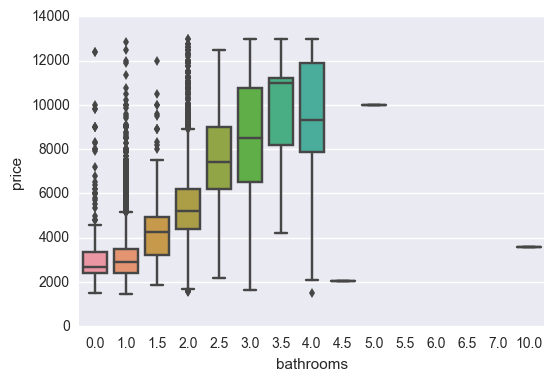

In [161]:
sns.boxplot(x=df['bathrooms'],y=df[(df['price']>=low) & (df['price']<=high)]['price'])

As we can see, there are some abormal data. Let's take a look at what happens.

In [155]:
df[df['bathrooms']==10] # Typo Problem

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
104459,10.0,2,424f8014bddc288d26da5fe81d0bea02,2016-04-09 04:34:31,***The building?s well-attended lobby welcomes...,W 52 St.,"[Doorman, Elevator, Fitness Center, Laundry in...",low,40.7633,6849204,-73.9849,0c71a59cb70215fbf49c9dd93efaa172,[https://photos.renthop.com/2/6849204_1f92b58a...,3600,260 W 52 St.


We inspect the listing manually and observe that the actuall number of bathrooms is 1 instead of 10.

In [156]:
df[df['bathrooms']==7]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
84566,7.0,5,0,2016-04-07 17:06:29,Extraordinary in every way. This single family...,West 9th St- High Class Townhome,[],low,40.7335,6840943,-73.9974,e6472c7237327dd3903b3d6f6a94515a,[https://photos.renthop.com/2/6840943_7f4b82cf...,60000,47th West 9th St


### Price wrt number of bedrooms

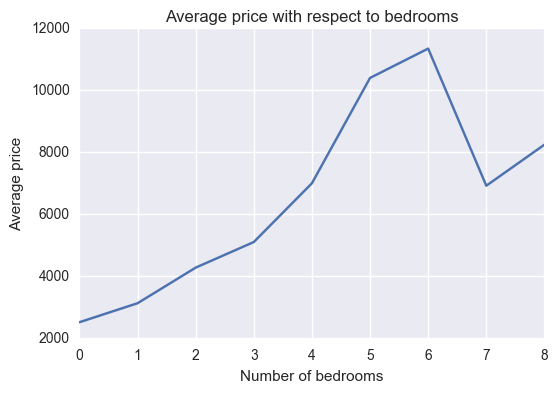

In [151]:
avg_price_bedrooms = y_train['price'].groupby(X_train['bedrooms']).mean()
plt.figure()
plt.plot(avg_price_bedrooms.index, avg_price_bedrooms.values)
plt.title('Average price with respect to bedrooms')
plt.xlabel('Number of bedrooms')
plt.ylabel('Average price')
plt.show()

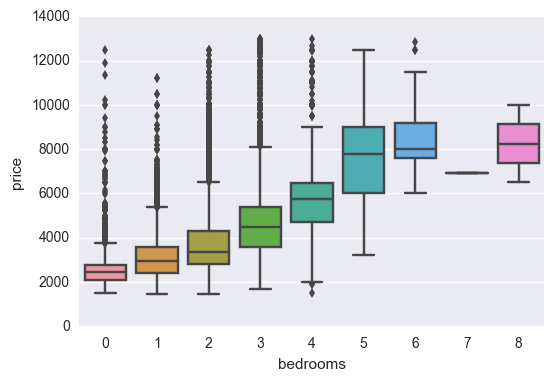

In [158]:
sns.boxplot(x=X_train['bedrooms'],y=y_train[(y_train['price']>=low) & (y_train['price']<=high)]['price'])

In [142]:
df[df['bedrooms']==8]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
11313,4.0,8,2d51ec2a54cf05468685ef80f504bb94,2016-06-25 06:09:20,Gorgeous 8 bedroom Duplex/4 full bathroom w/ ...,Greene Ave,"[Hardwood Floors, No Fee, Dogs Allowed, Cats A...",low,40.6881,7217045,-73.9553,9ba3641676cc717a8b65d59dac8545fb,[],6500,393 Greene Ave
28722,3.0,8,f8bff653aae7c7555b9c2388e98ab0ef,2016-06-13 02:47:37,Please note that this is a lease break /lease ...,98 Lincoln Place,"[Roof Deck, Pre-War, Cats Allowed]",low,40.6764,7154651,-73.9767,9d4e9396e7e256947ac6242aee963d88,[https://photos.renthop.com/2/7154651_2c0b55b7...,9995,98 Lincoln Place


### Price wrt addresses

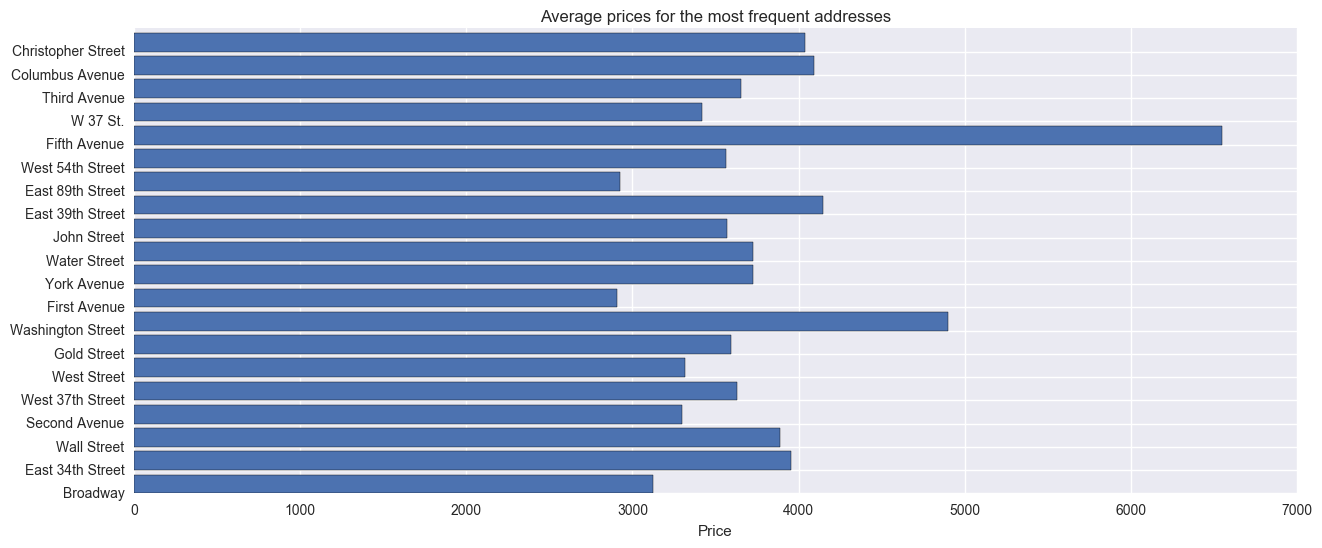

In [147]:
popular_addresses = address_counts.index[:20]
avg_price_addresses = y_train['price'].groupby(X_train['display_address']).mean()[popular_addresses]
avg_price_addresses
plt.figure(figsize=(15,6))
plt.barh(range(len(popular_addresses)), avg_price_addresses.values, tick_label=avg_price_addresses.index)
plt.xlabel('Price')
plt.title('Average prices for the most frequent addresses')

## Feature Extraction

### Extract Key Words in Addresses

In [15]:
def process_address(train_data, val_data, test_data):
    vec = CountVectorizer(min_df=1, binary=True)
    vec.fit(train_data['display_address'])
    new_columns =  vec.get_feature_names()
    #print new_columns
    new_columns = map(lambda x: 'address_'+str(x), new_columns)
    new_train = pd.DataFrame(index=train_data.index, data=vec.transform(train_data['display_address']).todense(), columns=new_columns)
    new_val = pd.DataFrame(index=val_data.index, data=vec.transform(val_data['display_address']).todense(), columns=new_columns)
    new_test = pd.DataFrame(index=test_data.index, data=vec.transform(test_data['display_address']).todense(), columns=new_columns)
    merge_train = pd.merge(train_data, new_train, left_index=True, right_index=True)
    merge_val = pd.merge(val_data, new_val, left_index=True, right_index=True)
    merge_test = pd.merge(test_data, new_test, left_index=True, right_index=True)
    return merge_train, merge_val, merge_test

### Extract Key Words in "Features"

In [24]:
def process_tags(train_data, val_data, test_data):
    vec = CountVectorizer(min_df=1, binary=True)
    train = train_data.copy()
    val = val_data.copy()
    test = test_data.copy()
    train.loc[:,'features'] = map(lambda x: ' '.join(x), train_data['features'])
    val.loc[:,'features'] = map(lambda x: ' '.join(x), val_data['features'])
    test.loc[:,'features'] = map(lambda x: ' '.join(x), test_data['features'])
    vec.fit(train['features'])
    new_columns =  vec.get_feature_names()
    new_columns = map(lambda x: 'feature_'+x.encode('utf-8').strip(), new_columns)
    new_train = pd.DataFrame(index=train.index, data=vec.transform(train['features']).todense(), columns=new_columns)
    new_val = pd.DataFrame(index=val.index, data=vec.transform( val['features']).todense(), columns=new_columns)
    new_test = pd.DataFrame(index=test.index, data=vec.transform( test['features']).todense(), columns=new_columns)
    merge_train = train_data.merge(new_train, left_index=True, right_index=True)
    merge_val = val_data.merge(new_val, left_index=True, right_index=True)
    merge_test = test_data.merge(new_test, left_index=True, right_index=True)
    return merge_train, merge_val, merge_test

### Add features to both training data and test data

In [17]:
def feature_extraction(oridata):
    data = oridata.copy()
    # Extract the number of "photos" and "features" for each listing
    data.ix[:,'num_photos']=data.ix[:,'photos'].apply(len)
    data.ix[:,'num_features']=data.ix[:,'features'].apply(len)
    data = data.drop('interest_level',1)
    data = data.drop('manager_id',1)
    return data

### Take out numeric data, transform and rescale

In [18]:
def select_numeric_rescale(train, val, test):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    # Ignore dummy variables
    scaled = ['bathrooms','bedrooms','latitude','listing_id','longitude','num_photos','num_features']
    X_numeric_train = train.select_dtypes(include=numerics)
    X_numeric_val = val.select_dtypes(include=numerics)
    X_numeric_test = test.select_dtypes(include=numerics)
    # Standardize
    scaler = StandardScaler()
    scaler.fit(X_numeric_train[scaled].values)
    X_numeric_train.ix[:,scaled] = scaler.transform(X_numeric_train[scaled])
    X_numeric_val.ix[:,scaled] = scaler.transform(X_numeric_val[scaled])
    X_numeric_test.ix[:,scaled] = scaler.transform(X_numeric_test[scaled])
    X_numeric_train = pd.DataFrame(data=X_numeric_train, columns=X_numeric_train.columns, index = X_numeric_train.index)
    X_numeric_val = pd.DataFrame(data=X_numeric_val, columns=X_numeric_val.columns, index = X_numeric_val.index)
    X_numeric_test = pd.DataFrame(data=X_numeric_test, columns=X_numeric_test.columns, index = X_numeric_test.index)
    return X_numeric_train, X_numeric_val, X_numeric_test

### Principle Component Analysis

#### Components Construction

In [19]:
def pca(X_train, X_val, X_test, c=100):
    pca = PCA(c) # 100 Components
    pca.fit(X_train)
    checkComp(X_train, pca)
    print np.sum(pca.explained_variance_ratio_[:c])
    return pca.transform(X_train), pca.transform(X_val), pca.transform(X_test)

#### Components Visualization

In [20]:
# Check what features contribute to the component
def checkComp(X_train, mypca, com=3, pre=10):
    cols = X_train.columns
    for c in range(com):
        sidx = sorted(range(len(cols)), key=lambda x: mypca.components_[c][x])
        scols = [cols[i] for i in sidx[:pre]]
        tmp = [i for i in range(0,pre)]
        val =  [mypca.components_[c][i] for i in sidx[:pre]]
        plt.figure(figsize=(8, 3))
        plt.barh(tmp, val, tick_label=scols)
        plt.title('Features contributing negatively to the component '+str(c+1))
        plt.xlabel('Weight on the component')
        plt.show()
        
        sidx = sorted(range(len(cols)), key=lambda x: -mypca.components_[c][x])
        scols = [cols[i] for i in sidx[:pre]]
        tmp = [i for i in range(0,pre)]
        val =  [mypca.components_[c][i] for i in sidx[:pre]]
        plt.figure(figsize=(8, 3))
        plt.barh(tmp, val, tick_label=scols)
        plt.title('Features contributing positively to the component '+str(c+1))
        plt.xlabel('Weight on the component')
        plt.show()
        

## Feature Selection

To select numeric features, we have several choices:
1. Embeded Method: We can use some linear models penalized with the L1 norm to make unimportant features has coefficient of zero.
2. Filter Method: Preprocess the features by using F-test, Correlation Matrix, etc.
3. Wrapper Method: Run model on subsets and score them

### Lasso feature selection

I've tried the recursive feature elimination method, but takes too much time, so we can instead use Lasso feature selection for the numeric data

In [21]:
# Embeded Method: Lasso 
# Reference: Wikipedia-Feature Selection
def lasso_feature_selection(X,y,num=-1):
    estimator = Lasso()
    estimator.fit(X,y)
    selector = SelectFromModel(estimator, prefit=True, threshold=0.5)
    X_new = selector.transform(X)
    # n_features indicates the number of features we want
    n_features = X_new.shape[1]
    if num >= 0:
        while n_features > num:
            selector.threshold += 0.1
            X_new = selector.transform(X)
            n_features = X_new.shape[1]
    print selector.get_support() # We can see that only the first two features "bedroom", "bathroom" remains
    return X_new

### F-regression feature selection

In [22]:
# Filter Method: f-regression
def freg(X, y, num=-1):
    cols = X.columns
    if num == -1:
        num = 10
    fs, ps = f_regression(X,y)
    sidx = sorted(range(len(cols)), key=lambda x: ps[x])[:num]
    return [cols[i] for i in sidx]

## Model Selection

### Feature Extraction

In [133]:
# Split Validation Set
X_train_set, X_val_set, y_train_set, y_val_set = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
print X_train_set.shape, X_val_set.shape, X_test.shape

# Add Feature Lengths
X_train_new = feature_extraction(X_train_set)
X_val_new = feature_extraction(X_val_set)
X_test_new = feature_extraction(X_test)

# Address/Tag Feature Extraction
# Notice that we only create word vector from training data
X_train_merge, X_val_merge, X_test_merge = process_address(X_train_new, X_val_new, X_test_new)
X_train_merge, X_val_merge, X_test_merge = process_tags(X_train_merge, X_val_merge, X_test_merge)

# Numerical Feature Standardization
X_train_numeric_merge, X_val_numeric_merge, X_test_numeric_merge = select_numeric_rescale(X_train_merge, X_val_merge, X_test_merge)
print X_train_numeric_merge.shape, X_val_numeric_merge.shape, X_test_numeric_merge.shape

(27636, 14) (11845, 14) (9871, 14)
(27636, 3040) (11845, 3040) (9871, 3040)


In [26]:
X_val_numeric_merge.head()

,bathrooms,bedrooms,latitude,listing_id,longitude,num_photos,num_features,address_02,address_03,address_04,...,feature_work,feature_wrap,feature_wv,feature_xoxo,feature_xxlarge,feature_yard,feature_year,feature_yoga,feature_york,feature_your
26631,-0.424215,-1.383719,-0.016608,0.682390,-0.021219,-0.438897,-0.879374,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66236,1.574355,0.413126,-0.031638,-0.400930,-0.042126,-1.541340,2.421855,0,0,0,...,1,0,0,0,0,0,0,0,0,0
31681,-0.424215,0.413126,-0.037803,1.087028,-0.039348,0.663546,0.898211,0,0,0,...,0,0,0,0,0,0,0,0,0,0
74032,1.574355,0.413126,-0.024572,-0.562335,-0.003575,0.387935,-0.371493,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33308,1.574355,0.413126,-0.196319,1.150862,0.009483,1.765989,-0.117552,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Feature Selection

In [27]:
# Dimension Reduction and Feature Selection
def featureSelFre(X_train, y_train, X_val, X_test, num=10):
    sig_cols = freg(X_train, y_train, num)
    X_train_new = X_train[sig_cols]
    X_val_new = X_val[sig_cols]
    X_test_new = X_test[sig_cols]
    print sig_cols
    return X_train_new, X_val_new, X_test_new

In [134]:
X_train_final, X_val_final, X_test_final = featureSelFre(X_train_numeric_merge, y_train_set, X_val_numeric_merge, X_test_numeric_merge, 100)
print X_train_final.shape
X_train_final.head()

['address_hudson', 'address_116th', u'bathrooms', u'bedrooms', 'feature_exclusive', 'feature_doorman', 'address_horn', 'address_57th', 'feature_elevator', 'num_features', 'feature_unit', 'feature_dining', 'feature_room', 'feature_dogs', 'feature_cats', 'feature_allowed', 'address_duane', 'address_class', 'address_townhome', 'feature_terrace', u'listing_id', 'address_7712', 'address_utrecht', 'feature_center', 'feature_fitness', 'feature_fireplace', 'feature_balcony', 'address_van', 'address_230', 'feature_pool', 'feature_swimming', 'address_street', 'feature_dishwasher', 'feature_space', 'address_end', 'feature_outdoor', 'feature_simplex', 'address_59th', 'feature_lowrise', 'address_west', 'feature_garden', 'address_high', 'feature_patio', 'feature_level', 'feature_multi', 'feature_deck', 'feature_roof', 'feature_war', 'feature_pre', 'address_86th', 'address_523b', 'address_oak', 'address_triple', 'feature_vacation', 'feature_prewar', 'feature_laundry', 'feature_in', 'address_fifth', '

,address_hudson,address_116th,bathrooms,bedrooms,feature_exclusive,feature_doorman,address_horn,address_57th,feature_elevator,num_features,...,address_cooper,feature_light,address_broadway,feature_green,address_murray,address_84th,feature_subway,address_ocean,address_seventh,feature_live
110381,0,0,-0.424215,-0.485297,0,1,0,0,1,0.136389,...,0,0,0,0,0,0,0,0,0,0
86993,0,0,-0.424215,0.413126,0,0,0,0,0,-0.625433,...,0,0,0,0,0,0,0,0,0,0
88220,0,0,-0.424215,-1.383719,0,0,0,0,0,-0.625433,...,0,0,0,0,0,0,0,0,0,0
76804,0,0,1.574355,0.413126,0,1,0,0,1,0.390330,...,0,0,0,0,0,0,0,0,0,0
51117,0,0,1.574355,2.209972,0,0,0,0,0,-0.371493,...,0,0,0,0,0,0,0,0,0,0


In [135]:
lr = LinearRegression()
lr.fit(X_train_final, y_train_set)
print 'Test MSE: {}'.format(mean_squared_error(y_test, lr.predict(X_test_final)))

Test MSE: 129720068.396


### Validation for Linear Models w/ F regression feature selection

We are using lasso and ridge regression

In [30]:
allK = [10**x for x in range(-2,8)] # Alpha takes 10^-6 to 10^2

cv_ls = []
cv_rr = []
for k in allK:
        ls = Lasso(alpha=k)
        ls.fit(X_train_final, y_train_set)
        rr = Ridge(alpha=k)
        rr.fit(X_train_final, y_train_set)
        y_val_pred_ls = ls.predict(X_val_final)
        y_val_pred_rr = rr.predict(X_val_final)
        cv_ls.append(mean_squared_error(y_val_set, y_val_pred_ls)) # Notice that we take log on price data and then take exp
        cv_rr.append(mean_squared_error(y_val_set, y_val_pred_rr))
        print y_val_pred_ls

/Users/Tang/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[ 5960.35407417  6022.48081228  4620.07463046 ...,  5140.29538657
  1612.71917086  2133.74459369]
[ 5948.33870599  6018.6008222   4611.43673398 ...,  5138.87966126
  1612.2811577   2137.65889913]
[ 5860.13697408  5966.79585227  4557.02403088 ...,  5131.44261778
  1615.77561115  2171.2255552 ]
[ 5522.35526659  6249.53352977  4247.32980592 ...,  5023.86386391
  1701.04944632  2243.07778793]
[ 4295.80715997  6305.28398904  4404.45380184 ...,  3742.97157407
  2372.01889844  2687.63083806]
[ 3702.29114073  4690.50747806  3702.29114073 ...,  3702.29114073
  3702.29114073  3702.29114073]
[ 3912.04931973  3912.04931973  3912.04931973 ...,  3912.04931973
  3912.04931973  3912.04931973]
[ 3912.04931973  3912.04931973  3912.04931973 ...,  3912.04931973
  3912.04931973  3912.04931973]
[ 3912.04931973  3912.04931973  3912.04931973 ...,  3912.04931973
  3912.04931973  3912.04931973]
[ 3912.04931973  3912.04931973  3912.04931973 ...,  3912.04931973
  3912.04931973  3912.04931973]


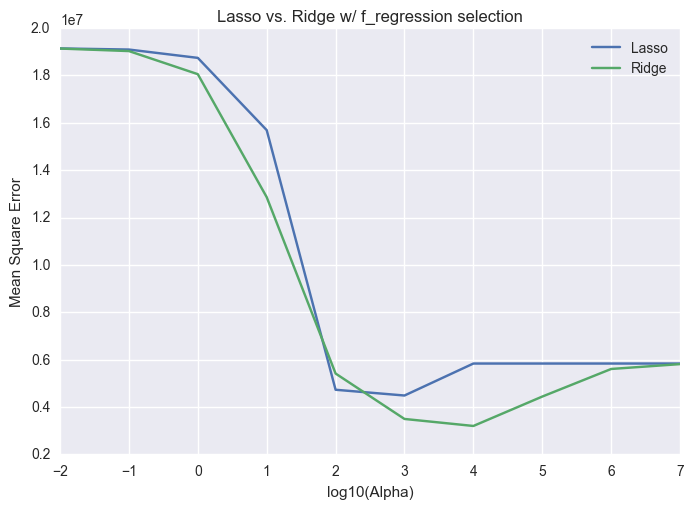

Best Validation Result for Lasso is 4483778.99603 when alpha is 1000
Best Validation Result for Ridge is 3198047.50262 when alpha is 10000


In [43]:
# Plot
plt.figure()
plt.plot(range(-2,8), cv_ls, label='Lasso')
plt.plot(range(-2,8), cv_rr, label='Ridge')
plt.legend()
plt.title('Lasso vs. Ridge w/ f_regression selection')
plt.xlabel('log10(Alpha)')
plt.ylabel('Mean Square Error')
plt.show()
print 'Best Validation Result for Lasso is {} when alpha is {}'.format(np.min(cv_ls), allK[np.argmin(cv_ls)])
print 'Best Validation Result for Ridge is {} when alpha is {}'.format(np.min(cv_rr), allK[np.argmin(cv_rr)])

### Validation for Gradient Boosing

In [69]:
# specify hyperparameters via map
param = {}
allR = np.linspace(0,20,11)
allR = map(lambda x: int(x), allR)
print allR
cv_gb = []
# Validation
for r in allR:
    dtrain = xgb.DMatrix(X_train_final, label=y_train_set)
    dval = xgb.DMatrix(X_val_final)
    model = xgb.train(param, dtrain, r)
    gb_val_preds = model.predict(dval)
    err = mean_squared_error(y_val_set, gb_val_preds)
    cv_gb.append(err)
    print err
print cv_gb
# make prediction


[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
19276059.58
6897087.95244
3971330.7822
3211499.30208
3445418.26703
3249014.90339
3175372.79388
3271251.75249
3263288.15546
3489137.7105
3448922.38208
[19276059.580012664, 6897087.9524398139, 3971330.7822021125, 3211499.3020821698, 3445418.2670310512, 3249014.903391039, 3175372.7938782349, 3271251.7524921484, 3263288.1554588233, 3489137.7105011358, 3448922.3820840665]


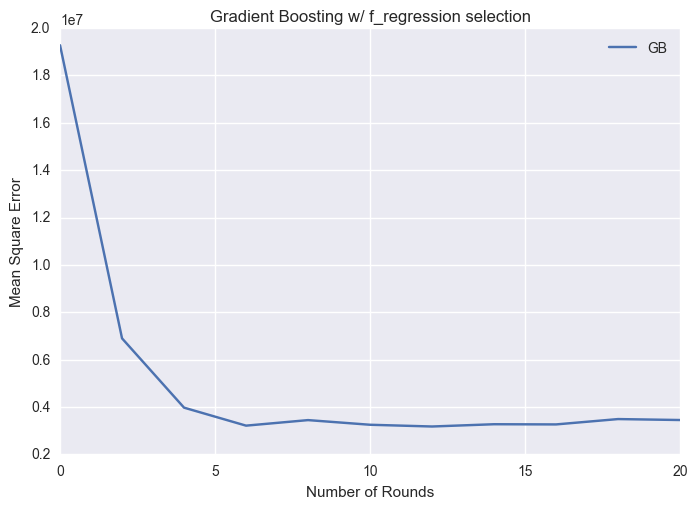

Best Validation Result for Gradient Boosting is 3175372.79388 when number of rounds is 12


In [70]:
# Plot
plt.figure()
plt.plot(allR, cv_gb, label='GB')
plt.legend()
plt.title('Gradient Boosting w/ f_regression selection')
plt.xlabel('Number of Rounds')
plt.ylabel('Mean Square Error')
plt.show()
print 'Best Validation Result for Gradient Boosting is {} when number of rounds is {}'.format(np.min(cv_gb), allR[np.argmin(cv_gb)])

## PCA Feature Extraction

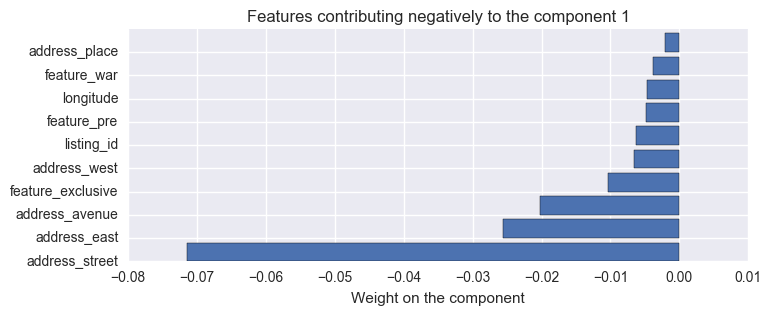

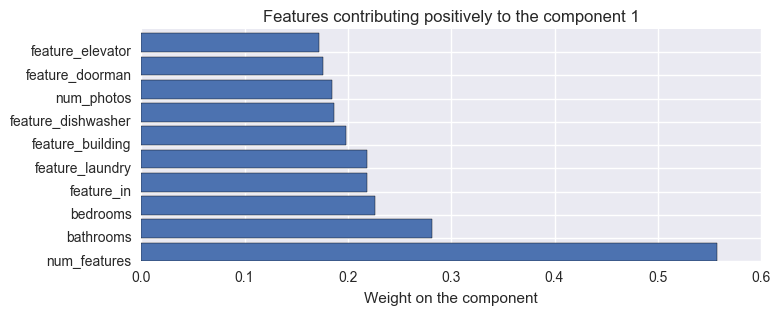

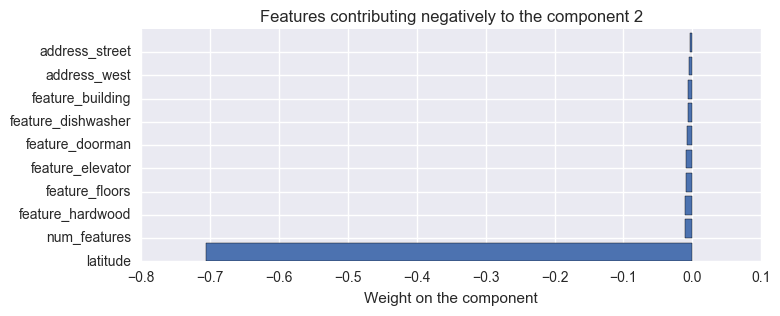

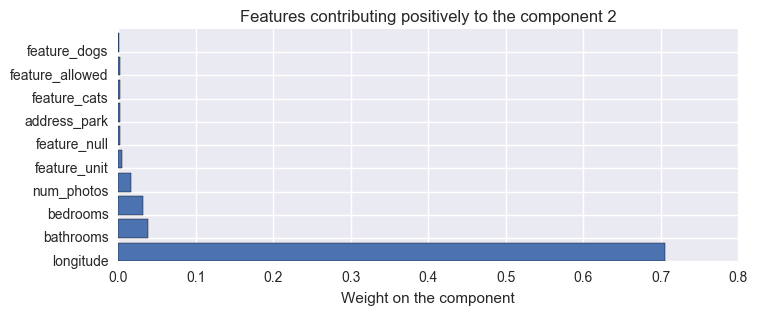

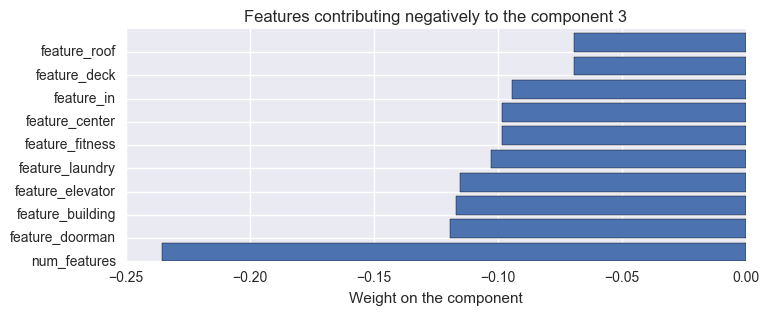

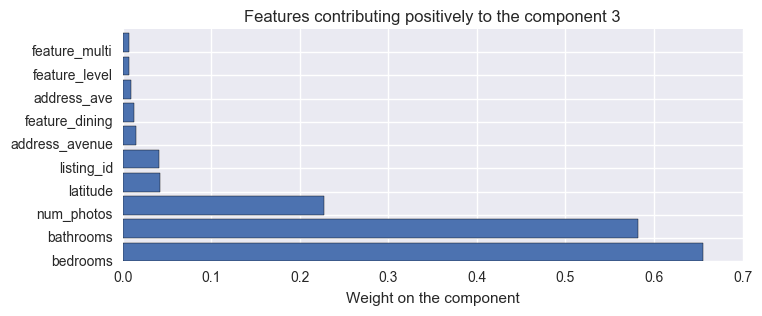

0.927945996039


In [34]:
X_train_pca, X_val_pca, X_test_pca = pca(X_train_numeric_merge, X_val_numeric_merge, X_test_numeric_merge, 100)

### Linear Models

In [35]:
allK = [10**x for x in range(-2,8)] # Alpha takes 10^-2 to 10^10
cv_ls_pca = []
cv_rr_pca = []
for k in allK:
        ls = Lasso(alpha=k)
        ls.fit(X_train_pca, y_train_set)
        rr = Ridge(alpha=k)
        rr.fit(X_train_pca, y_train_set)
        y_val_pred_ls = ls.predict(X_val_pca)
        y_val_pred_rr = rr.predict(X_val_pca)
        cv_ls_pca.append(mean_squared_error(y_val_set, y_val_pred_ls))
        cv_rr_pca.append(mean_squared_error(y_val_set, y_val_pred_rr))

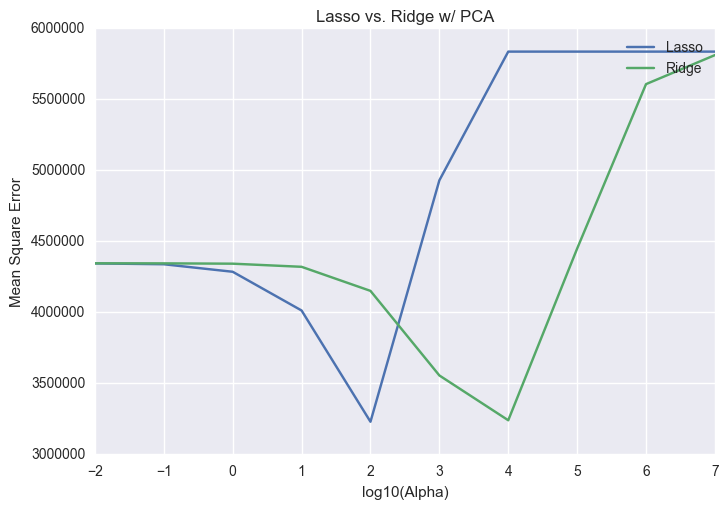

Best Validation Result for Lasso is 3229350.81502 when alpha is 100
Best Validation Result for Ridge is 3239764.63248 when alpha is 10000


In [45]:
# Plot
plt.figure()
plt.plot(range(-2,8), cv_ls_pca, label='Lasso')
plt.plot(range(-2,8), cv_rr_pca, label='Ridge')
plt.legend()
plt.title('Lasso vs. Ridge w/ PCA')
plt.xlabel('log10(Alpha)')
plt.ylabel('Mean Square Error')
plt.show()
print 'Best Validation Result for Lasso is {} when alpha is {}'.format(np.min(cv_ls_pca), allK[np.argmin(cv_ls_pca)])
print 'Best Validation Result for Ridge is {} when alpha is {}'.format(np.min(cv_rr_pca), allK[np.argmin(cv_rr_pca)])

### Gradient Boosting

In [67]:
# specify parameters via map
param = {}
allR = np.linspace(0,20,11)
allR = map(lambda x: int(x), allR)
print allR
cv_gb_pca = []
# Validation
for r in allR:
    dtrain = xgb.DMatrix(X_train_pca,label=y_train_set)
    dval = xgb.DMatrix(X_val_pca)
    model = xgb.train(param, dtrain, r)
    gb_val_preds = model.predict(dval)
    err = mean_squared_error(y_val_set, gb_val_preds)
    cv_gb_pca.append(err)
    print err
print cv_gb_pca
# make prediction


[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
19276059.58
267736354.459
780042936.876
1325211272.23
1806580744.85
2200708418.33
2510263987.54
2745859240.2
2922714084.11
3053905887.14
3105924604.1
[19276059.580012664, 267736354.45858595, 780042936.87594628, 1325211272.2309833, 1806580744.8531415, 2200708418.3340163, 2510263987.5418735, 2745859240.1975155, 2922714084.1050725, 3053905887.135128, 3105924604.104476]


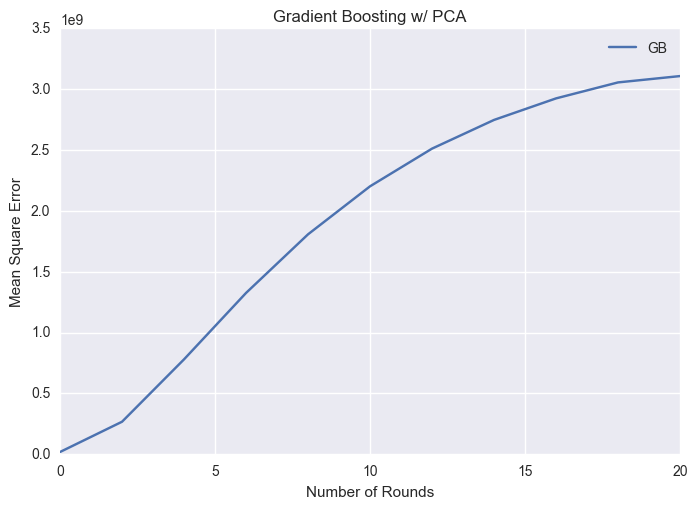

Best Validation Result for Gradient Boosting is 19276059.58 when max depth is 0


In [71]:
# Plot
plt.figure()
plt.plot(allR, cv_gb_pca, label='GB')
plt.legend()
plt.title('Gradient Boosting w/ PCA')
plt.xlabel('Number of Rounds')
plt.ylabel('Mean Square Error')
plt.show()
print 'Best Validation Result for Gradient Boosting is {} when max depth is {}'.format(np.min(cv_gb_pca), allR[np.argmin(cv_gb_pca)])

## Evaluation Of Best Model

### The best model is Gradient Boosting with max depth of  with f regression feature selection

In [64]:
dtrain = xgb.DMatrix(X_train_final, label=y_train_set)
model = xgb.train(param, dtrain, 12)
dtest = xgb.DMatrix(X_test_final)
gb_test_preds = model.predict(dtest)

In [65]:
print 'Test MSE: {}'.format(mean_squared_error(y_test, gb_test_preds))
print 'R2: {}'.format(r2_score(y_test, gb_test_preds))

Test MSE: 118866373.892
R2: 0.0157615762548


In [63]:
rr = Ridge(alpha=allK[np.argmin(cv_rr)])
rr.fit(X_train_final, y_train_set)
print 'Test MSE: {}'.format(mean_squared_error(y_test, rr.predict(X_test_final)))

Test MSE: 118115424.022
